## 개요
이 프로젝트에서는 X-RAY 이미지의 관상면(Frontal plane)을 기반으로 폐렴을 진단할 수 있는 이진 분류 모델을 개발합니다.

## 목차
1. 문제 정의
2. 데이터 수집
3. 데이터 이해
4. 데이터 준비
5. 모델 구현
6. 모델 개선
7. 회고
8. 참고

## 1. 문제 정의
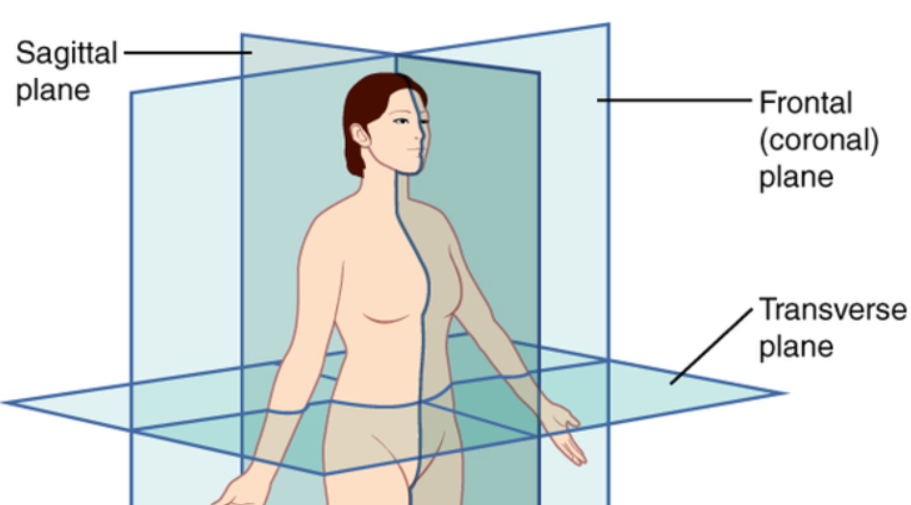

목표
- X-RAY 이미지의 관상면(Frontal plane)을 기반으로 폐렴을 진단할 수 있는 모델 구현

입력
- 환자의 X-ray 관상면 이미지

출력
- 폐렴 진단 결과 ('NORMAL' 또는 'PNEUMONIA')

문제 유형
- 이진 분류 (Binary Classification)

성능 목표
- 높은 정확도(Accuracy)와 재현율(Recall)을 달성하여 폐렴 환자를 정확히 식별한다.

## 2. 데이터 수집
- kaggle의 [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?select=chest_xray)을 활용해 모델의 학습을 진행한다.

## 3. 데이터 이해
#### 의료 영상 데이터
- 의료 영상에는 CT, X-RAY, MRI 등 다양한 종류가 있다.
- X-RAY 데이터를 활용하기때문에 X-RAY에 대해 알 필요가 있다.

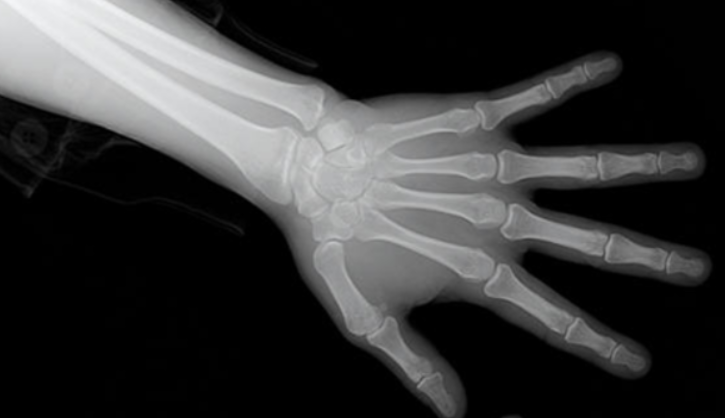

- X-RAY는 방사선의 일종으로 지방, 근육, 천, 종이같이 밀도가 낮은 것은 수월하게 통과하지만, 밀도가 높은 뼈, 금속 같은 물질은 잘 통과하지 못한다. 보기 어려웠던 인체 내부를 투사해 의료용으로 사용되기 시작했다.
- 부위에 따라 명암이 다르게 나온다.
- 뼈는 흰색, 공기는 검은색으로 표현된다.

출처
- https://namu.wiki/w/X%EC%84%A0

**폐렴의 정의와 폐렴 구별법**
- 폐렴은 쉽게 말해 폐에 염증이 생기는 것을 말한다.

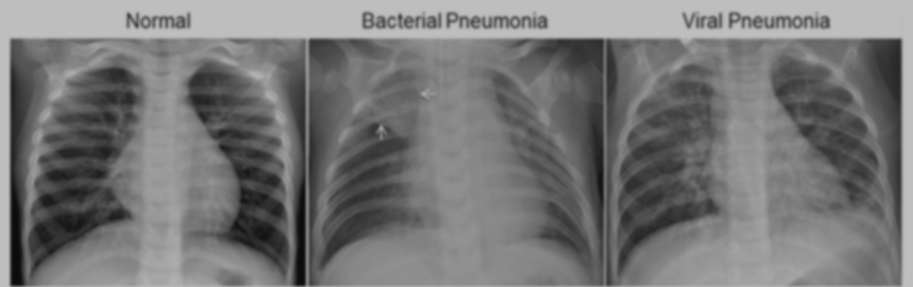

- X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰되는 것이 폐렴이다.
- 세균성(Bacteria)은 왼쪽 화살표가 나타내는 위치인 왼쪽 위에 분포된다.
- 바이러스성(Viral)은 조직 사이에 분포된다.

## 4. 데이터 준비

#### 4.1 데이터 불러오기

In [41]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
import kagglehub

warnings.filterwarnings(action='ignore')

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = path
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 초기 파라미터 설정
BATCH_SIZE = 16
EPOCHS = 10

- kagglehub에서 필요한 데이터를 import 합니다.

In [42]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- train은 5216개, test는 624개, val은 16개가 있습니다.
- 개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.

In [43]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- train은 4185개, val는 1047개로 이전보다 val 개수가 많아졌습니다.

In [44]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/NORMAL/NORMAL2-IM-0618-0001.jpeg
Pneumonia image path
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train/PNEUMONIA/person1411_virus_2415.jpeg


- 파일 경로를 보면 양성, 음성 여부를 알 수 있습니다. 실제로 수치가 일치하는 지 확인해보겠습니다.

In [45]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


- train 데이터의 개수인 4185개와 일치합니다.
- 양성이 음성보다 약 3배가 많은 걸 확인할 수 있습니다.

In [46]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

- tf.data instance를 만들겠습니다. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해주는데, 이는 속도와 안정성을 동시에 관리할 수 있으며, GPU 기반의 효율적인 병렬 연산을 하기 위함입니다.

In [47]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


#### 4.2 데이터 전처리
**이미지 사이즈 변환**
- 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄입니다.

**데이터 라벨링**
- 이미지에는 라벨 데이터가 따로 없습니다. 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 사용해서 데이터를 라벨링합니다.

In [8]:
# 이미지 사이즈 변환
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 데이터 라벨링
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.cast(parts[-2] == "PNEUMONIA", tf.float32)   # 폐렴이면 양성(1.0), 노말이면 음성(0.0)

In [9]:
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [48]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [49]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0.0


- 사이즈가 180 x 180으로 변환되어 있고 라벨도 잘 들어가 있는 걸 볼 수 있습니다.

In [50]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
print(TEST_IMAGE_COUNT)

624


- 훈련 데이터에 전처리를 했다면 테스트 데이터에도 동일하게 전처리를 해줘야합니다.

In [51]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

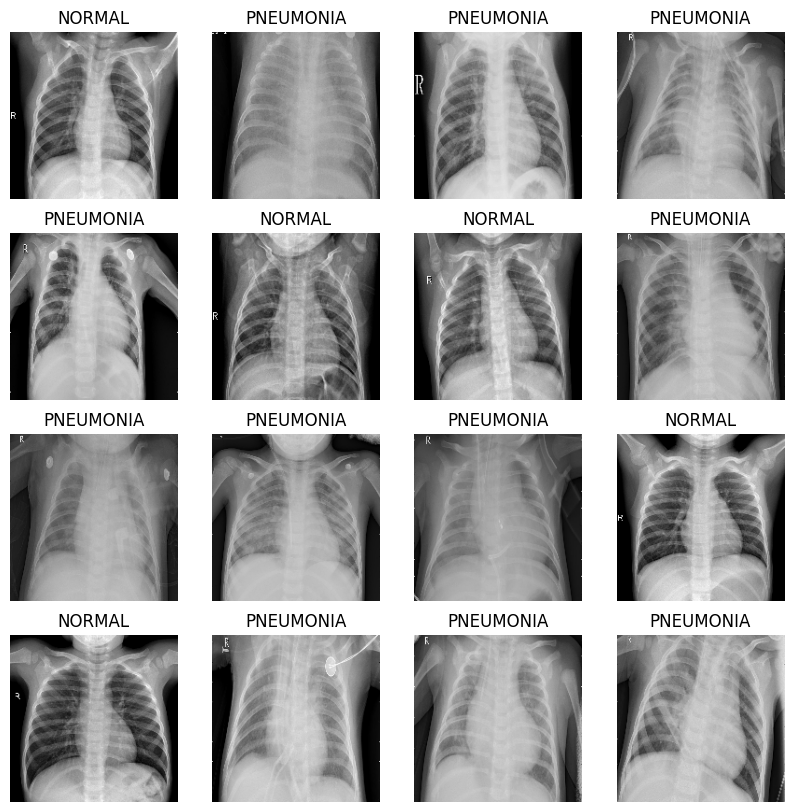

In [52]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

- 효율적으로 학습 할 수 있게 tf.data를 사용해서 데이터를 변환하고 확인해보겠습니다.

## 5. 모델 개발

#### 5.1 Base 모델 (CNN)

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

- conv block은 두 번의 conv 연산을 하고, Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결한 후에 Max Pooling을 합니다.

In [16]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

- dense block의 특이점은 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있다는 점입니다.
- [Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift](https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf) 논문과
[Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks](https://arxiv.org/pdf/1905.05928) 논문에서 견해의 차이가 있지만, 두 기법을 동시에 사용했을 때 성능 향상에 도움이 될지 확인해보겠습니다.

In [17]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

**데이터 imbalance 처리**
- 이전에 train 데이터를 살펴봤을 때, 양성인 Pneumonia가 음성인 Normal에 비해 3배가 많았었습니다.
- 데이터가 imbalance한 경우 학습 효과가 좋지 않으니 Weight balancing 테크닉으로 불균형 문제를 해결해보겠습니다.

In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


- weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

**모델 훈련**
- 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다.
- optimizer로 'adam'을 사용합니다.
- 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [19]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 124s 343ms/step - accuracy: 0.7356 - loss: 0.5067 - precision: 0.9267 - recall: 0.6957 - val_accuracy: 0.7337 - val_loss: 0.7528 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 65s 252ms/step - accuracy: 0.9063 - loss: 0.2336 - precision: 0.9726 - recall: 0.8997 - val_accuracy: 0.7337 - val_loss: 1.3554 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 63s 242ms/step - accuracy: 0.9294 - loss: 0.1962 - precision: 0.9778 - recall: 0.9259 - val_accuracy: 0.8183 - val_loss: 0.3511 - val_precision: 0.8019 - val_recall: 1.0000
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 64s 247ms/step - accuracy: 0.9284 - loss: 0.1982 - precision: 0.9765 - recall: 0.9259 - val_accuracy: 0.8846 - val_loss: 0.2477 - val_precision: 0.8649 - val_recall: 0.9987
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 62s 237ms/step - accuracy: 0.9471 - loss: 0.1400 - precision: 0.9793 - recall: 0.9493 - val_accuracy: 0.892

**결과 확인**
- Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 확인해봅니다.

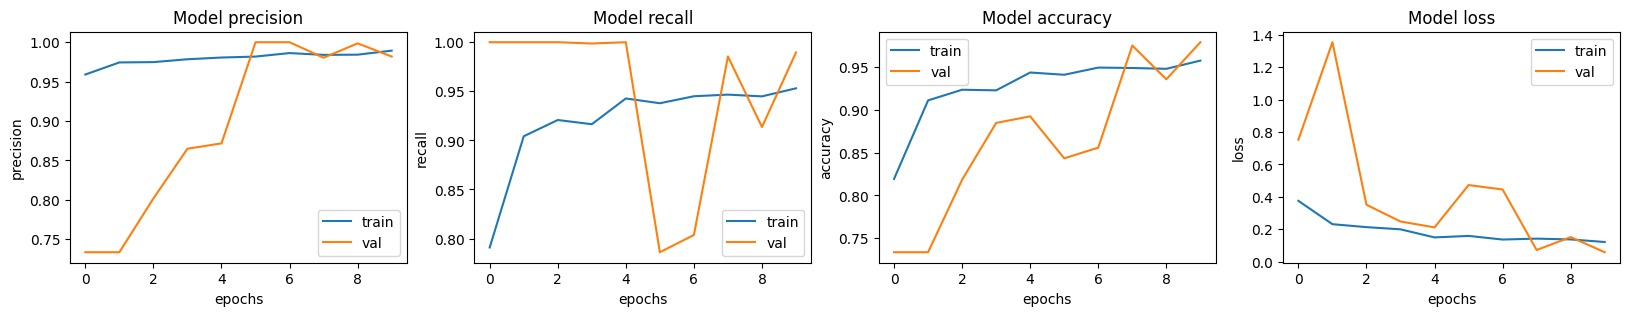

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.7646 - loss: 0.8243 - precision: 0.7406 - recall: 1.0000
Loss: 0.8777546882629395,
Accuracy: 0.7371794581413269,
Precision: 0.7039711475372314,
Recall: 1.0


- 테스트 데이터로 모델을 평가해본 결과 약 73%의 정확성을 가지는 걸 확인할 수 있습니다.
- 의사는 90% 이상 정확하게 예측하기때문에 base 모델의 성능을 개선해보겠습니다.

#### 5.2 Base model + Data augmentation
- X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문에 Data augmentation 도입은 신중해야 합니다.

In [34]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

# 배치처리 함수에 augment를 적용합니다.
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.map(
            augment, # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

- 좌우 반전을 적용하고 데이터를 시각화해본다면 아래와 같습니다.

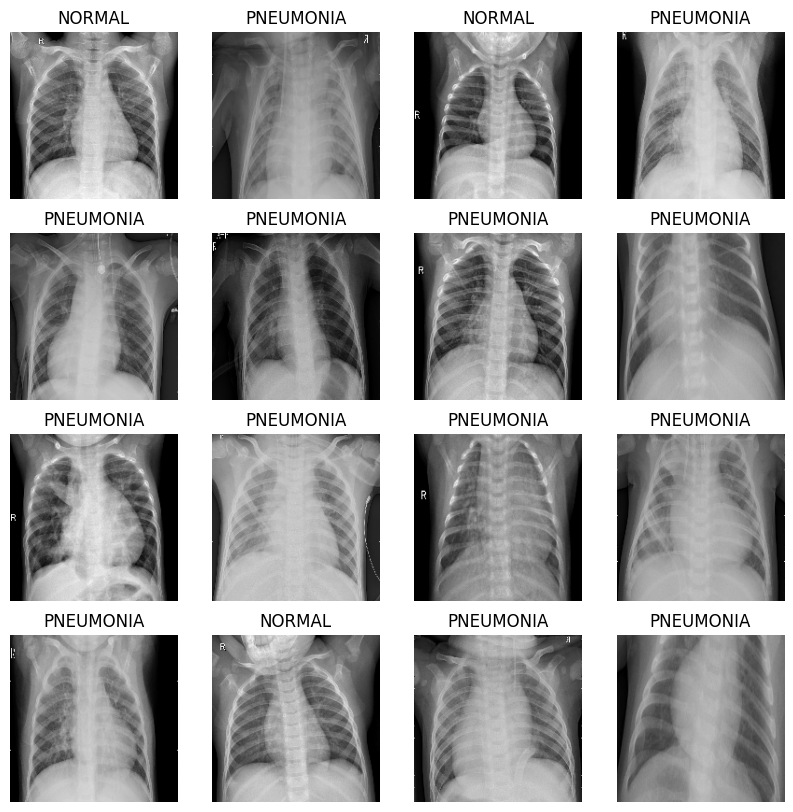

In [35]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

- 이미지를 살펴보면 augment 하기 전과 별 차이가 없어보입니다.
- 실제로 성능에도 차이가 없는지 모델을 학습하고 결과를 확인해보겠습니다.

**모델 훈련**

In [38]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 116s 331ms/step - accuracy: 0.7262 - loss: 0.5377 - precision: 0.9174 - recall: 0.6914 - val_accuracy: 0.7279 - val_loss: 0.6512 - val_precision: 0.7279 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 65s 249ms/step - accuracy: 0.8883 - loss: 0.2847 - precision: 0.9648 - recall: 0.8797 - val_accuracy: 0.7288 - val_loss: 1.3205 - val_precision: 0.7288 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 63s 241ms/step - accuracy: 0.9155 - loss: 0.2385 - precision: 0.9691 - recall: 0.9160 - val_accuracy: 0.8279 - val_loss: 0.3725 - val_precision: 0.8092 - val_recall: 0.9987
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 63s 243ms/step - accuracy: 0.9240 - loss: 0.1978 - precision: 0.9776 - recall: 0.9181 - val_accuracy: 0.7106 - val_loss: 0.8876 - val_precision: 1.0000 - val_recall: 0.6076
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 67s 257ms/step - accuracy: 0.9150 - loss: 0.1929 - precision: 0.9738 - recall: 0.9098 - val_accuracy: 0.801

**결과 확인**

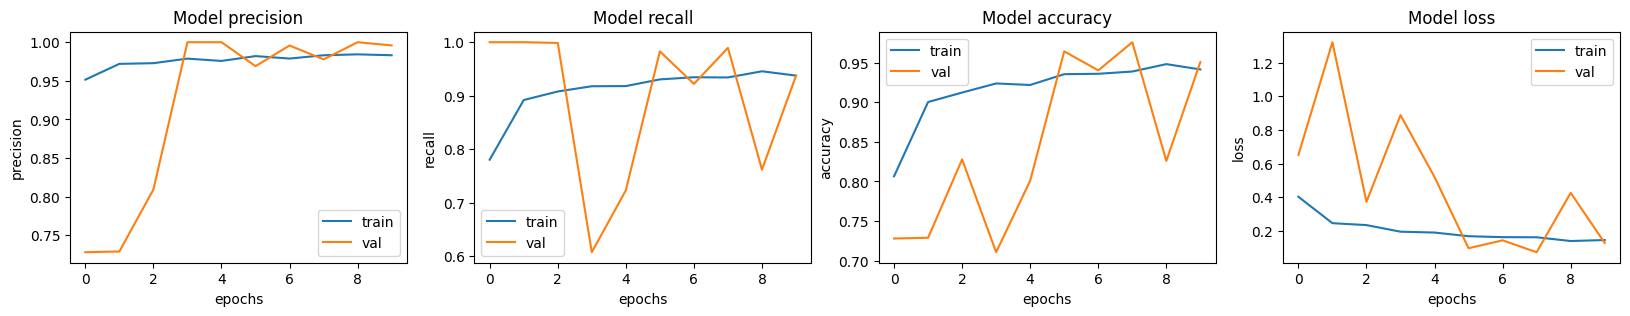

In [39]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [40]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.8432 - loss: 0.4479 - precision: 0.8153 - recall: 0.9695
Loss: 0.4111611843109131,
Accuracy: 0.8477563858032227,
Precision: 0.8213507533073425,
Recall: 0.9666666388511658


- 결과를 보면 모델의 정확도는 5.1 Base 모델의 73%보다 높은 84%의 정확도를 가지는 걸 확인할 수 있습니다.

#### 5.3 Base model + Data imbalance
- 5.1에서 불균형한 데이터를 고려해 class_weight를 설정해주었습니다.
- 데이터가 불균형한 상태에서 모델을 학습시키면 어떤 성능을 가지는 지 확인해보겠습니다.

**모델 훈련**

In [53]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        # class_weight=class_weight, # class_weight 생략
    )

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 104s 289ms/step - accuracy: 0.7912 - loss: 0.4699 - precision: 0.9272 - recall: 0.7752 - val_accuracy: 0.7346 - val_loss: 0.8347 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 63s 243ms/step - accuracy: 0.9317 - loss: 0.2086 - precision: 0.9576 - recall: 0.9508 - val_accuracy: 0.7327 - val_loss: 1.1391 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 60s 230ms/step - accuracy: 0.9364 - loss: 0.1762 - precision: 0.9571 - recall: 0.9568 - val_accuracy: 0.9231 - val_loss: 0.1768 - val_precision: 0.9067 - val_recall: 0.9987
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 63s 241ms/step - accuracy: 0.9495 - loss: 0.1500 - precision: 0.9635 - recall: 0.9686 - val_accuracy: 0.9433 - val_loss: 0.1340 - val_precision: 0.9501 - val_recall: 0.9738
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 61s 234ms/step - accuracy: 0.9473 - loss: 0.1524 - precision: 0.9608 - recall: 0.9686 - val_accuracy: 0.951

**결과 확인**

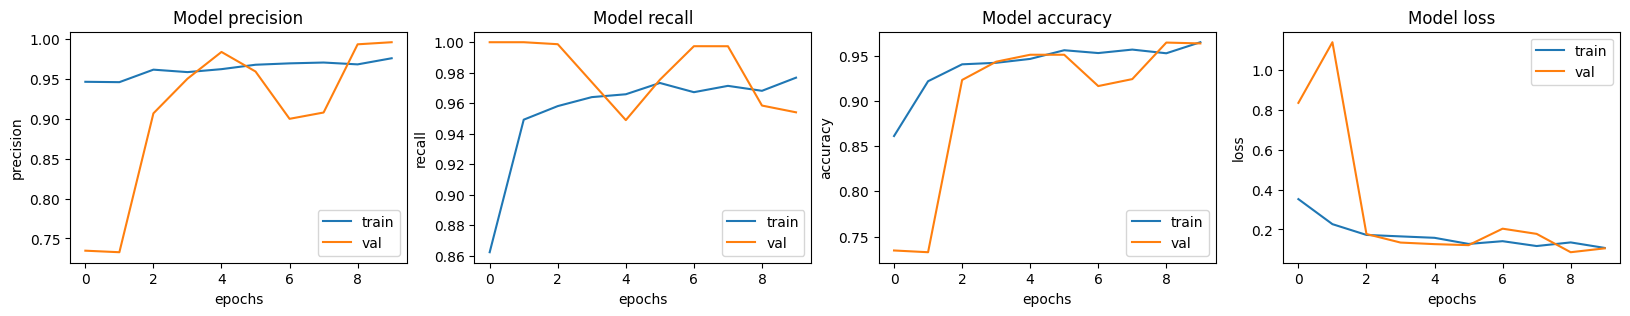

In [54]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [55]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.8197 - loss: 0.5662 - precision: 0.7897 - recall: 0.9740
Loss: 0.5744366645812988,
Accuracy: 0.8125,
Precision: 0.7780040502548218,
Recall: 0.9794871807098389


- 데이터가 불균형한 상태로 학습시키면 오히려 5.1 Base 모델보다 정확도가 올라간 것을 확인할 수 있었지만, 목표 성능인 90%에 한참 미치지 못했다.

#### 5.4 ResNet-18
- ResNet의 특징이라면 Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지했다는 점입니다.
- Resnet으로 모델 성능을 확인해보겠습니다.
- 구현할 ResNet-18의 구조는 아래와 같습니다.

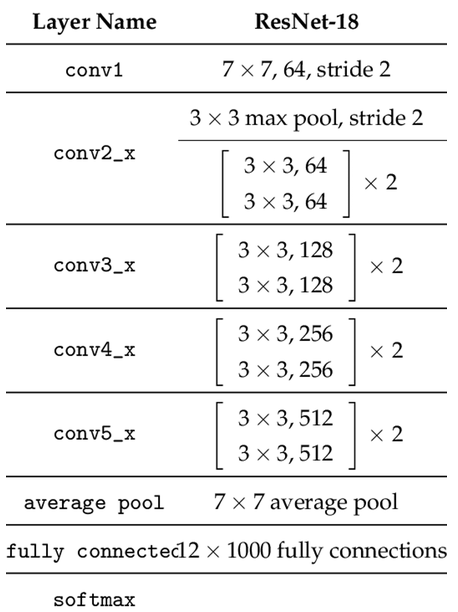

In [1]:
def identity_block(x, filters):
    shortcut = x
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([shortcut, x])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [2]:
def resnet18(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = identity_block(x, 64)
    x = identity_block(x, 64)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)

    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)

    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)

    x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
with tf.device('/GPU:0'):
    model = resnet18((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), 1)
    print(model.summary())

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

```
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_12 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_162 (Conv2D)             (None, 90, 90, 64)   9472        input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_162 (BatchN (None, 90, 90, 64)   256         conv2d_162[0][0]                 
__________________________________________________________________________________________________
activation_162 (Activation)     (None, 90, 90, 64)   0           batch_normalization_162[0][0]    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 45, 45, 64)   0           activation_162[0][0]             
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 45, 45, 64)   36928       max_pooling2d_10[0][0]           
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, 45, 45, 64)   256         conv2d_163[0][0]                 
__________________________________________________________________________________________________
activation_163 (Activation)     (None, 45, 45, 64)   0           batch_normalization_163[0][0]    
__________________________________________________________________________________________________
conv2d_164 (Conv2D)             (None, 45, 45, 64)   36928       activation_163[0][0]             
__________________________________________________________________________________________________
batch_normalization_164 (BatchN (None, 45, 45, 64)   256         conv2d_164[0][0]                 
__________________________________________________________________________________________________
add_64 (Add)                    (None, 45, 45, 64)   0           max_pooling2d_10[0][0]           
                                                                 batch_normalization_164[0][0]    
__________________________________________________________________________________________________
activation_164 (Activation)     (None, 45, 45, 64)   0           add_64[0][0]                     
__________________________________________________________________________________________________
conv2d_165 (Conv2D)             (None, 45, 45, 64)   36928       activation_164[0][0]             
__________________________________________________________________________________________________
batch_normalization_165 (BatchN (None, 45, 45, 64)   256         conv2d_165[0][0]                 
__________________________________________________________________________________________________
activation_165 (Activation)     (None, 45, 45, 64)   0           batch_normalization_165[0][0]    
__________________________________________________________________________________________________
conv2d_166 (Conv2D)             (None, 45, 45, 64)   36928       activation_165[0][0]             
__________________________________________________________________________________________________
batch_normalization_166 (BatchN (None, 45, 45, 64)   256         conv2d_166[0][0]                 
__________________________________________________________________________________________________
add_65 (Add)                    (None, 45, 45, 64)   0           activation_164[0][0]             
                                                                 batch_normalization_166[0][0]    
__________________________________________________________________________________________________
activation_166 (Activation)     (None, 45, 45, 64)   0           add_65[0][0]                     
__________________________________________________________________________________________________
conv2d_167 (Conv2D)             (None, 45, 45, 128)  73856       activation_166[0][0]             
__________________________________________________________________________________________________
batch_normalization_167 (BatchN (None, 45, 45, 128)  512         conv2d_167[0][0]                 
__________________________________________________________________________________________________
activation_167 (Activation)     (None, 45, 45, 128)  0           batch_normalization_167[0][0]    
__________________________________________________________________________________________________
conv2d_168 (Conv2D)             (None, 45, 45, 128)  147584      activation_167[0][0]             
__________________________________________________________________________________________________
batch_normalization_168 (BatchN (None, 45, 45, 128)  512         conv2d_168[0][0]                 
__________________________________________________________________________________________________
activation_168 (Activation)     (None, 45, 45, 128)  0           batch_normalization_168[0][0]    
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 45, 45, 128)  147584      activation_168[0][0]             
__________________________________________________________________________________________________
batch_normalization_169 (BatchN (None, 45, 45, 128)  512         conv2d_169[0][0]                 
__________________________________________________________________________________________________
add_66 (Add)                    (None, 45, 45, 128)  0           activation_167[0][0]             
                                                                 batch_normalization_169[0][0]    
__________________________________________________________________________________________________
activation_169 (Activation)     (None, 45, 45, 128)  0           add_66[0][0]                     
__________________________________________________________________________________________________
conv2d_170 (Conv2D)             (None, 45, 45, 128)  147584      activation_169[0][0]             
__________________________________________________________________________________________________
batch_normalization_170 (BatchN (None, 45, 45, 128)  512         conv2d_170[0][0]                 
__________________________________________________________________________________________________
activation_170 (Activation)     (None, 45, 45, 128)  0           batch_normalization_170[0][0]    
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 45, 45, 128)  147584      activation_170[0][0]             
__________________________________________________________________________________________________
batch_normalization_171 (BatchN (None, 45, 45, 128)  512         conv2d_171[0][0]                 
__________________________________________________________________________________________________
add_67 (Add)                    (None, 45, 45, 128)  0           activation_169[0][0]             
                                                                 batch_normalization_171[0][0]    
__________________________________________________________________________________________________
activation_171 (Activation)     (None, 45, 45, 128)  0           add_67[0][0]                     
__________________________________________________________________________________________________
conv2d_172 (Conv2D)             (None, 45, 45, 256)  295168      activation_171[0][0]             
__________________________________________________________________________________________________
batch_normalization_172 (BatchN (None, 45, 45, 256)  1024        conv2d_172[0][0]                 
__________________________________________________________________________________________________
activation_172 (Activation)     (None, 45, 45, 256)  0           batch_normalization_172[0][0]    
__________________________________________________________________________________________________
conv2d_173 (Conv2D)             (None, 45, 45, 256)  590080      activation_172[0][0]             
__________________________________________________________________________________________________
batch_normalization_173 (BatchN (None, 45, 45, 256)  1024        conv2d_173[0][0]                 
__________________________________________________________________________________________________
activation_173 (Activation)     (None, 45, 45, 256)  0           batch_normalization_173[0][0]    
__________________________________________________________________________________________________
conv2d_174 (Conv2D)             (None, 45, 45, 256)  590080      activation_173[0][0]             
__________________________________________________________________________________________________
batch_normalization_174 (BatchN (None, 45, 45, 256)  1024        conv2d_174[0][0]                 
__________________________________________________________________________________________________
add_68 (Add)                    (None, 45, 45, 256)  0           activation_172[0][0]             
                                                                 batch_normalization_174[0][0]    
__________________________________________________________________________________________________
activation_174 (Activation)     (None, 45, 45, 256)  0           add_68[0][0]                     
__________________________________________________________________________________________________
conv2d_175 (Conv2D)             (None, 45, 45, 256)  590080      activation_174[0][0]             
__________________________________________________________________________________________________
batch_normalization_175 (BatchN (None, 45, 45, 256)  1024        conv2d_175[0][0]                 
__________________________________________________________________________________________________
activation_175 (Activation)     (None, 45, 45, 256)  0           batch_normalization_175[0][0]    
__________________________________________________________________________________________________
conv2d_176 (Conv2D)             (None, 45, 45, 256)  590080      activation_175[0][0]             
__________________________________________________________________________________________________
batch_normalization_176 (BatchN (None, 45, 45, 256)  1024        conv2d_176[0][0]                 
__________________________________________________________________________________________________
add_69 (Add)                    (None, 45, 45, 256)  0           activation_174[0][0]             
                                                                 batch_normalization_176[0][0]    
__________________________________________________________________________________________________
activation_176 (Activation)     (None, 45, 45, 256)  0           add_69[0][0]                     
__________________________________________________________________________________________________
conv2d_177 (Conv2D)             (None, 45, 45, 512)  1180160     activation_176[0][0]             
__________________________________________________________________________________________________
batch_normalization_177 (BatchN (None, 45, 45, 512)  2048        conv2d_177[0][0]                 
__________________________________________________________________________________________________
activation_177 (Activation)     (None, 45, 45, 512)  0           batch_normalization_177[0][0]    
__________________________________________________________________________________________________
conv2d_178 (Conv2D)             (None, 45, 45, 512)  2359808     activation_177[0][0]             
__________________________________________________________________________________________________
batch_normalization_178 (BatchN (None, 45, 45, 512)  2048        conv2d_178[0][0]                 
__________________________________________________________________________________________________
activation_178 (Activation)     (None, 45, 45, 512)  0           batch_normalization_178[0][0]    
__________________________________________________________________________________________________
conv2d_179 (Conv2D)             (None, 45, 45, 512)  2359808     activation_178[0][0]             
__________________________________________________________________________________________________
batch_normalization_179 (BatchN (None, 45, 45, 512)  2048        conv2d_179[0][0]                 
__________________________________________________________________________________________________
add_70 (Add)                    (None, 45, 45, 512)  0           activation_177[0][0]             
                                                                 batch_normalization_179[0][0]    
__________________________________________________________________________________________________
activation_179 (Activation)     (None, 45, 45, 512)  0           add_70[0][0]                     
__________________________________________________________________________________________________
conv2d_180 (Conv2D)             (None, 45, 45, 512)  2359808     activation_179[0][0]             
__________________________________________________________________________________________________
batch_normalization_180 (BatchN (None, 45, 45, 512)  2048        conv2d_180[0][0]                 
__________________________________________________________________________________________________
activation_180 (Activation)     (None, 45, 45, 512)  0           batch_normalization_180[0][0]    
__________________________________________________________________________________________________
conv2d_181 (Conv2D)             (None, 45, 45, 512)  2359808     activation_180[0][0]             
__________________________________________________________________________________________________
batch_normalization_181 (BatchN (None, 45, 45, 512)  2048        conv2d_181[0][0]                 
__________________________________________________________________________________________________
add_71 (Add)                    (None, 45, 45, 512)  0           activation_179[0][0]             
                                                                 batch_normalization_181[0][0]    
__________________________________________________________________________________________________
activation_181 (Activation)     (None, 45, 45, 512)  0           add_71[0][0]                     
__________________________________________________________________________________________________
average_pooling2d_2 (AveragePoo (None, 6, 6, 512)    0           activation_181[0][0]             
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 18432)        0           average_pooling2d_2[0][0]        
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1000)         18433000    flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 1)            1001        dense_6[0][0]                    
==================================================================================================
Total params: 32,549,457
Trainable params: 32,539,857
Non-trainable params: 9,600
__________________________________________________________________________________________________
None
Epoch 1/10
261/261 [==============================] - 115s 404ms/step - loss: 2.0534 - accuracy: 0.7713 - precision: 0.9079 - recall: 0.7709 - val_loss: 0.4485 - val_accuracy: 0.8048 - val_precision: 0.7935 - val_recall: 0.9921
Epoch 2/10
261/261 [==============================] - 106s 406ms/step - loss: 0.2111 - accuracy: 0.9174 - precision: 0.9717 - recall: 0.9157 - val_loss: 0.1988 - val_accuracy: 0.9202 - val_precision: 0.9645 - val_recall: 0.9253
Epoch 3/10
261/261 [==============================] - 106s 406ms/step - loss: 0.1740 - accuracy: 0.9284 - precision: 0.9743 - recall: 0.9283 - val_loss: 0.1283 - val_accuracy: 0.9510 - val_precision: 0.9541 - val_recall: 0.9803
Epoch 4/10
261/261 [==============================] - 106s 406ms/step - loss: 0.4061 - accuracy: 0.9148 - precision: 0.9712 - recall: 0.9125 - val_loss: 90.5567 - val_accuracy: 0.5952 - val_precision: 0.8279 - val_recall: 0.5668
Epoch 5/10
261/261 [==============================] - 106s 406ms/step - loss: 0.2482 - accuracy: 0.9183 - precision: 0.9723 - recall: 0.9163 - val_loss: 0.1615 - val_accuracy: 0.9327 - val_precision: 0.9887 - val_recall: 0.9187
Epoch 6/10
261/261 [==============================] - 106s 406ms/step - loss: 0.1318 - accuracy: 0.9502 - precision: 0.9843 - recall: 0.9481 - val_loss: 0.1174 - val_accuracy: 0.9529 - val_precision: 0.9463 - val_recall: 0.9921
Epoch 7/10
261/261 [==============================] - 106s 405ms/step - loss: 0.1143 - accuracy: 0.9576 - precision: 0.9861 - recall: 0.9567 - val_loss: 0.1364 - val_accuracy: 0.9548 - val_precision: 0.9661 - val_recall: 0.9724
Epoch 8/10
261/261 [==============================] - 106s 407ms/step - loss: 0.1069 - accuracy: 0.9595 - precision: 0.9861 - recall: 0.9591 - val_loss: 0.2040 - val_accuracy: 0.9144 - val_precision: 0.9787 - val_recall: 0.9029
Epoch 9/10
261/261 [==============================] - 106s 407ms/step - loss: 0.0950 - accuracy: 0.9631 - precision: 0.9878 - recall: 0.9624 - val_loss: 0.1341 - val_accuracy: 0.9490 - val_precision: 0.9622 - val_recall: 0.9685
Epoch 10/10
261/261 [==============================] - 106s 407ms/step - loss: 0.0968 - accuracy: 0.9631 - precision: 0.9887 - recall: 0.9613 - val_loss: 0.1489 - val_accuracy: 0.9375 - val_precision: 0.9794 - val_recall: 0.9345
```

**결과 확인**

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

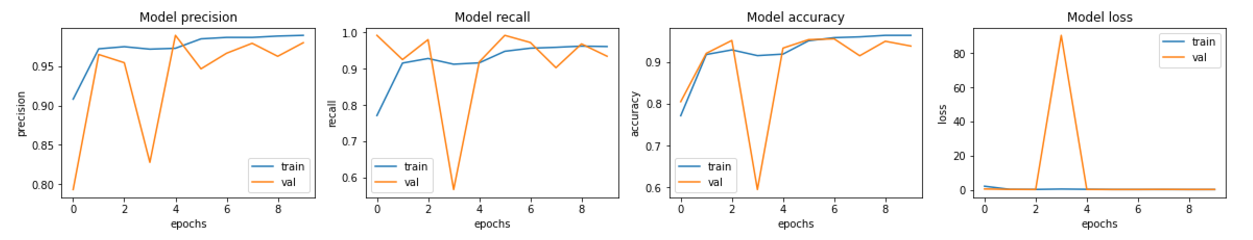

- epoch 3~4 사이에서 loss가 급격히 상승하는 결과를 볼 수 있었습니다.

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

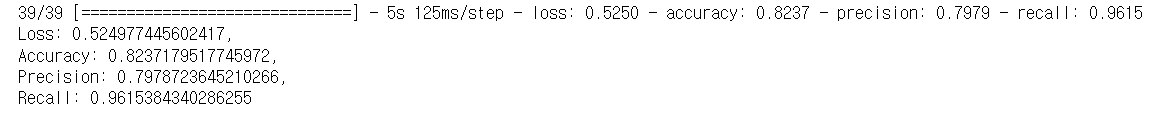

- 테스트 결과도 82%의 정확도와 96%의 재현율을 확인할 수 있었습니다.

#### 5.5 ResNet-18 + Data augmentation
- Resnet-18 모델의 성능을 개선해보기 위해 Data augmentation을 적용해보겠습니다.

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

# 배치처리 함수에 augment를 적용합니다.
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.map(
            augment, # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

**모델 훈련**

In [ ]:
with tf.device('/GPU:0'):
    model = resnet18((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), 1)
    print(model.summary())

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

```
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_11 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, 90, 90, 64)   9472        input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_142 (BatchN (None, 90, 90, 64)   256         conv2d_142[0][0]                 
__________________________________________________________________________________________________
activation_142 (Activation)     (None, 90, 90, 64)   0           batch_normalization_142[0][0]    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 45, 45, 64)   0           activation_142[0][0]             
__________________________________________________________________________________________________
conv2d_143 (Conv2D)             (None, 45, 45, 64)   36928       max_pooling2d_9[0][0]            
__________________________________________________________________________________________________
batch_normalization_143 (BatchN (None, 45, 45, 64)   256         conv2d_143[0][0]                 
__________________________________________________________________________________________________
activation_143 (Activation)     (None, 45, 45, 64)   0           batch_normalization_143[0][0]    
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 45, 45, 64)   36928       activation_143[0][0]             
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 45, 45, 64)   256         conv2d_144[0][0]                 
__________________________________________________________________________________________________
add_56 (Add)                    (None, 45, 45, 64)   0           max_pooling2d_9[0][0]            
                                                                 batch_normalization_144[0][0]    
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 45, 45, 64)   0           add_56[0][0]                     
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 45, 45, 64)   36928       activation_144[0][0]             
__________________________________________________________________________________________________
batch_normalization_145 (BatchN (None, 45, 45, 64)   256         conv2d_145[0][0]                 
__________________________________________________________________________________________________
activation_145 (Activation)     (None, 45, 45, 64)   0           batch_normalization_145[0][0]    
__________________________________________________________________________________________________
conv2d_146 (Conv2D)             (None, 45, 45, 64)   36928       activation_145[0][0]             
__________________________________________________________________________________________________
batch_normalization_146 (BatchN (None, 45, 45, 64)   256         conv2d_146[0][0]                 
__________________________________________________________________________________________________
add_57 (Add)                    (None, 45, 45, 64)   0           activation_144[0][0]             
                                                                 batch_normalization_146[0][0]    
__________________________________________________________________________________________________
activation_146 (Activation)     (None, 45, 45, 64)   0           add_57[0][0]                     
__________________________________________________________________________________________________
conv2d_147 (Conv2D)             (None, 45, 45, 128)  73856       activation_146[0][0]             
__________________________________________________________________________________________________
batch_normalization_147 (BatchN (None, 45, 45, 128)  512         conv2d_147[0][0]                 
__________________________________________________________________________________________________
activation_147 (Activation)     (None, 45, 45, 128)  0           batch_normalization_147[0][0]    
__________________________________________________________________________________________________
conv2d_148 (Conv2D)             (None, 45, 45, 128)  147584      activation_147[0][0]             
__________________________________________________________________________________________________
batch_normalization_148 (BatchN (None, 45, 45, 128)  512         conv2d_148[0][0]                 
__________________________________________________________________________________________________
activation_148 (Activation)     (None, 45, 45, 128)  0           batch_normalization_148[0][0]    
__________________________________________________________________________________________________
conv2d_149 (Conv2D)             (None, 45, 45, 128)  147584      activation_148[0][0]             
__________________________________________________________________________________________________
batch_normalization_149 (BatchN (None, 45, 45, 128)  512         conv2d_149[0][0]                 
__________________________________________________________________________________________________
add_58 (Add)                    (None, 45, 45, 128)  0           activation_147[0][0]             
                                                                 batch_normalization_149[0][0]    
__________________________________________________________________________________________________
activation_149 (Activation)     (None, 45, 45, 128)  0           add_58[0][0]                     
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 45, 45, 128)  147584      activation_149[0][0]             
__________________________________________________________________________________________________
batch_normalization_150 (BatchN (None, 45, 45, 128)  512         conv2d_150[0][0]                 
__________________________________________________________________________________________________
activation_150 (Activation)     (None, 45, 45, 128)  0           batch_normalization_150[0][0]    
__________________________________________________________________________________________________
conv2d_151 (Conv2D)             (None, 45, 45, 128)  147584      activation_150[0][0]             
__________________________________________________________________________________________________
batch_normalization_151 (BatchN (None, 45, 45, 128)  512         conv2d_151[0][0]                 
__________________________________________________________________________________________________
add_59 (Add)                    (None, 45, 45, 128)  0           activation_149[0][0]             
                                                                 batch_normalization_151[0][0]    
__________________________________________________________________________________________________
activation_151 (Activation)     (None, 45, 45, 128)  0           add_59[0][0]                     
__________________________________________________________________________________________________
conv2d_152 (Conv2D)             (None, 45, 45, 256)  295168      activation_151[0][0]             
__________________________________________________________________________________________________
batch_normalization_152 (BatchN (None, 45, 45, 256)  1024        conv2d_152[0][0]                 
__________________________________________________________________________________________________
activation_152 (Activation)     (None, 45, 45, 256)  0           batch_normalization_152[0][0]    
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 45, 45, 256)  590080      activation_152[0][0]             
__________________________________________________________________________________________________
batch_normalization_153 (BatchN (None, 45, 45, 256)  1024        conv2d_153[0][0]                 
__________________________________________________________________________________________________
activation_153 (Activation)     (None, 45, 45, 256)  0           batch_normalization_153[0][0]    
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, 45, 45, 256)  590080      activation_153[0][0]             
__________________________________________________________________________________________________
batch_normalization_154 (BatchN (None, 45, 45, 256)  1024        conv2d_154[0][0]                 
__________________________________________________________________________________________________
add_60 (Add)                    (None, 45, 45, 256)  0           activation_152[0][0]             
                                                                 batch_normalization_154[0][0]    
__________________________________________________________________________________________________
activation_154 (Activation)     (None, 45, 45, 256)  0           add_60[0][0]                     
__________________________________________________________________________________________________
conv2d_155 (Conv2D)             (None, 45, 45, 256)  590080      activation_154[0][0]             
__________________________________________________________________________________________________
batch_normalization_155 (BatchN (None, 45, 45, 256)  1024        conv2d_155[0][0]                 
__________________________________________________________________________________________________
activation_155 (Activation)     (None, 45, 45, 256)  0           batch_normalization_155[0][0]    
__________________________________________________________________________________________________
conv2d_156 (Conv2D)             (None, 45, 45, 256)  590080      activation_155[0][0]             
__________________________________________________________________________________________________
batch_normalization_156 (BatchN (None, 45, 45, 256)  1024        conv2d_156[0][0]                 
__________________________________________________________________________________________________
add_61 (Add)                    (None, 45, 45, 256)  0           activation_154[0][0]             
                                                                 batch_normalization_156[0][0]    
__________________________________________________________________________________________________
activation_156 (Activation)     (None, 45, 45, 256)  0           add_61[0][0]                     
__________________________________________________________________________________________________
conv2d_157 (Conv2D)             (None, 45, 45, 512)  1180160     activation_156[0][0]             
__________________________________________________________________________________________________
batch_normalization_157 (BatchN (None, 45, 45, 512)  2048        conv2d_157[0][0]                 
__________________________________________________________________________________________________
activation_157 (Activation)     (None, 45, 45, 512)  0           batch_normalization_157[0][0]    
__________________________________________________________________________________________________
conv2d_158 (Conv2D)             (None, 45, 45, 512)  2359808     activation_157[0][0]             
__________________________________________________________________________________________________
batch_normalization_158 (BatchN (None, 45, 45, 512)  2048        conv2d_158[0][0]                 
__________________________________________________________________________________________________
activation_158 (Activation)     (None, 45, 45, 512)  0           batch_normalization_158[0][0]    
__________________________________________________________________________________________________
conv2d_159 (Conv2D)             (None, 45, 45, 512)  2359808     activation_158[0][0]             
__________________________________________________________________________________________________
batch_normalization_159 (BatchN (None, 45, 45, 512)  2048        conv2d_159[0][0]                 
__________________________________________________________________________________________________
add_62 (Add)                    (None, 45, 45, 512)  0           activation_157[0][0]             
                                                                 batch_normalization_159[0][0]    
__________________________________________________________________________________________________
activation_159 (Activation)     (None, 45, 45, 512)  0           add_62[0][0]                     
__________________________________________________________________________________________________
conv2d_160 (Conv2D)             (None, 45, 45, 512)  2359808     activation_159[0][0]             
__________________________________________________________________________________________________
batch_normalization_160 (BatchN (None, 45, 45, 512)  2048        conv2d_160[0][0]                 
__________________________________________________________________________________________________
activation_160 (Activation)     (None, 45, 45, 512)  0           batch_normalization_160[0][0]    
__________________________________________________________________________________________________
conv2d_161 (Conv2D)             (None, 45, 45, 512)  2359808     activation_160[0][0]             
__________________________________________________________________________________________________
batch_normalization_161 (BatchN (None, 45, 45, 512)  2048        conv2d_161[0][0]                 
__________________________________________________________________________________________________
add_63 (Add)                    (None, 45, 45, 512)  0           activation_159[0][0]             
                                                                 batch_normalization_161[0][0]    
__________________________________________________________________________________________________
activation_161 (Activation)     (None, 45, 45, 512)  0           add_63[0][0]                     
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 6, 6, 512)    0           activation_161[0][0]             
__________________________________________________________________________________________________
flatten (Flatten)               (None, 18432)        0           average_pooling2d_1[0][0]        
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1000)         18433000    flatten[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1)            1001        dense_4[0][0]                    
==================================================================================================
Total params: 32,549,457
Trainable params: 32,539,857
Non-trainable params: 9,600
__________________________________________________________________________________________________
None
Epoch 1/10
261/261 [==============================] - 117s 400ms/step - loss: 2.3991 - accuracy: 0.7150 - precision: 0.8793 - recall: 0.7151 - val_loss: 0.9905 - val_accuracy: 0.7356 - val_precision: 0.7372 - val_recall: 0.9961
Epoch 2/10
261/261 [==============================] - 106s 406ms/step - loss: 0.2772 - accuracy: 0.8963 - precision: 0.9636 - recall: 0.8944 - val_loss: 0.6771 - val_accuracy: 0.7788 - val_precision: 0.7753 - val_recall: 0.9843
Epoch 3/10
261/261 [==============================] - 106s 408ms/step - loss: 0.1745 - accuracy: 0.9332 - precision: 0.9768 - recall: 0.9325 - val_loss: 0.2474 - val_accuracy: 0.8981 - val_precision: 0.8808 - val_recall: 0.9961
Epoch 4/10
261/261 [==============================] - 106s 408ms/step - loss: 0.1514 - accuracy: 0.9409 - precision: 0.9776 - recall: 0.9420 - val_loss: 0.1185 - val_accuracy: 0.9587 - val_precision: 0.9826 - val_recall: 0.9607
Epoch 5/10
261/261 [==============================] - 106s 408ms/step - loss: 0.1351 - accuracy: 0.9485 - precision: 0.9823 - recall: 0.9478 - val_loss: 0.1181 - val_accuracy: 0.9519 - val_precision: 0.9825 - val_recall: 0.9518
Epoch 6/10
261/261 [==============================] - 106s 408ms/step - loss: 0.1223 - accuracy: 0.9535 - precision: 0.9850 - recall: 0.9520 - val_loss: 0.7147 - val_accuracy: 0.8490 - val_precision: 0.9139 - val_recall: 0.8768
Epoch 7/10
261/261 [==============================] - 107s 409ms/step - loss: 0.1179 - accuracy: 0.9547 - precision: 0.9850 - recall: 0.9536 - val_loss: 1.3243 - val_accuracy: 0.6654 - val_precision: 0.9976 - val_recall: 0.5458
Epoch 8/10
261/261 [==============================] - 106s 408ms/step - loss: 0.1381 - accuracy: 0.9478 - precision: 0.9798 - recall: 0.9496 - val_loss: 0.3234 - val_accuracy: 0.8490 - val_precision: 0.8326 - val_recall: 0.9948
Epoch 9/10
261/261 [==============================] - 106s 408ms/step - loss: 0.1151 - accuracy: 0.9535 - precision: 0.9840 - recall: 0.9530 - val_loss: 0.1058 - val_accuracy: 0.9596 - val_precision: 0.9853 - val_recall: 0.9595
Epoch 10/10
261/261 [==============================] - 106s 407ms/step - loss: 0.0979 - accuracy: 0.9648 - precision: 0.9884 - recall: 0.9639 - val_loss: 0.0995 - val_accuracy: 0.9606 - val_precision: 0.9548 - val_recall: 0.9935
```

**결과 확인**

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

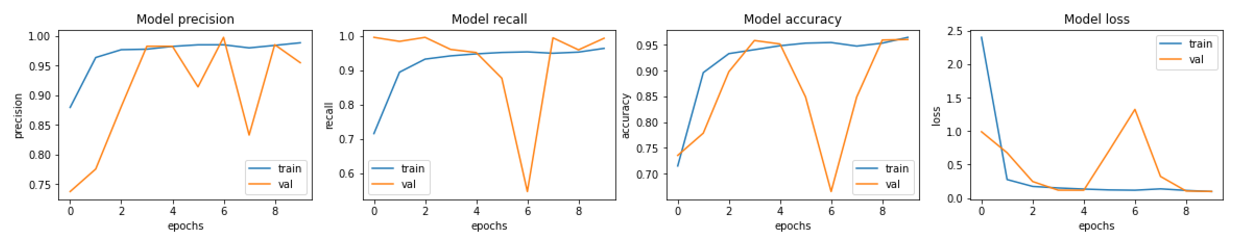

- epoch 6에서 loss가 급격히 증가하는 문제가 보입니다.

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

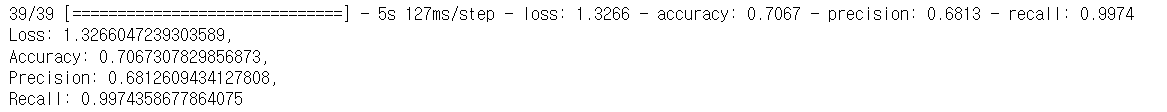

- 정확도는 70%지만 재현율이 1에 가깝게 나온 것을 확인할 수 있었습니다.

#### 5.6 Resnet-18 + Data augmentation + early stopping
- 5.4, 5.5에서 특정 epoch 이후에 공통적으로 loss가 급격히 증가하는 현상이 있었습니다.
- 과적합 이후에 나타나는 현상으로 예상되기때문에 loss가 증가하는 시점에 학습을 종료시킬 수 있게 early stopping을 적용해보겠습니다.

**모델 훈련**

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

with tf.device('/GPU:0'):
    model = resnet18((IMAGE_SIZE[0], IMAGE_SIZE[1], 3), 1)
    print(model.summary())

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        callbacks=[callback],
        class_weight=class_weight,
    )

```
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_14 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_202 (Conv2D)             (None, 90, 90, 64)   9472        input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_202 (BatchN (None, 90, 90, 64)   256         conv2d_202[0][0]                 
__________________________________________________________________________________________________
activation_202 (Activation)     (None, 90, 90, 64)   0           batch_normalization_202[0][0]    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 45, 45, 64)   0           activation_202[0][0]             
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 45, 45, 64)   36928       max_pooling2d_12[0][0]           
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 45, 45, 64)   256         conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 45, 45, 64)   0           batch_normalization_203[0][0]    
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 45, 45, 64)   36928       activation_203[0][0]             
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 45, 45, 64)   256         conv2d_204[0][0]                 
__________________________________________________________________________________________________
add_80 (Add)                    (None, 45, 45, 64)   0           max_pooling2d_12[0][0]           
                                                                 batch_normalization_204[0][0]    
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 45, 45, 64)   0           add_80[0][0]                     
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 45, 45, 64)   36928       activation_204[0][0]             
__________________________________________________________________________________________________
batch_normalization_205 (BatchN (None, 45, 45, 64)   256         conv2d_205[0][0]                 
__________________________________________________________________________________________________
activation_205 (Activation)     (None, 45, 45, 64)   0           batch_normalization_205[0][0]    
__________________________________________________________________________________________________
conv2d_206 (Conv2D)             (None, 45, 45, 64)   36928       activation_205[0][0]             
__________________________________________________________________________________________________
batch_normalization_206 (BatchN (None, 45, 45, 64)   256         conv2d_206[0][0]                 
__________________________________________________________________________________________________
add_81 (Add)                    (None, 45, 45, 64)   0           activation_204[0][0]             
                                                                 batch_normalization_206[0][0]    
__________________________________________________________________________________________________
activation_206 (Activation)     (None, 45, 45, 64)   0           add_81[0][0]                     
__________________________________________________________________________________________________
conv2d_207 (Conv2D)             (None, 45, 45, 128)  73856       activation_206[0][0]             
__________________________________________________________________________________________________
batch_normalization_207 (BatchN (None, 45, 45, 128)  512         conv2d_207[0][0]                 
__________________________________________________________________________________________________
activation_207 (Activation)     (None, 45, 45, 128)  0           batch_normalization_207[0][0]    
__________________________________________________________________________________________________
conv2d_208 (Conv2D)             (None, 45, 45, 128)  147584      activation_207[0][0]             
__________________________________________________________________________________________________
batch_normalization_208 (BatchN (None, 45, 45, 128)  512         conv2d_208[0][0]                 
__________________________________________________________________________________________________
activation_208 (Activation)     (None, 45, 45, 128)  0           batch_normalization_208[0][0]    
__________________________________________________________________________________________________
conv2d_209 (Conv2D)             (None, 45, 45, 128)  147584      activation_208[0][0]             
__________________________________________________________________________________________________
batch_normalization_209 (BatchN (None, 45, 45, 128)  512         conv2d_209[0][0]                 
__________________________________________________________________________________________________
add_82 (Add)                    (None, 45, 45, 128)  0           activation_207[0][0]             
                                                                 batch_normalization_209[0][0]    
__________________________________________________________________________________________________
activation_209 (Activation)     (None, 45, 45, 128)  0           add_82[0][0]                     
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 45, 45, 128)  147584      activation_209[0][0]             
__________________________________________________________________________________________________
batch_normalization_210 (BatchN (None, 45, 45, 128)  512         conv2d_210[0][0]                 
__________________________________________________________________________________________________
activation_210 (Activation)     (None, 45, 45, 128)  0           batch_normalization_210[0][0]    
__________________________________________________________________________________________________
conv2d_211 (Conv2D)             (None, 45, 45, 128)  147584      activation_210[0][0]             
__________________________________________________________________________________________________
batch_normalization_211 (BatchN (None, 45, 45, 128)  512         conv2d_211[0][0]                 
__________________________________________________________________________________________________
add_83 (Add)                    (None, 45, 45, 128)  0           activation_209[0][0]             
                                                                 batch_normalization_211[0][0]    
__________________________________________________________________________________________________
activation_211 (Activation)     (None, 45, 45, 128)  0           add_83[0][0]                     
__________________________________________________________________________________________________
conv2d_212 (Conv2D)             (None, 45, 45, 256)  295168      activation_211[0][0]             
__________________________________________________________________________________________________
batch_normalization_212 (BatchN (None, 45, 45, 256)  1024        conv2d_212[0][0]                 
__________________________________________________________________________________________________
activation_212 (Activation)     (None, 45, 45, 256)  0           batch_normalization_212[0][0]    
__________________________________________________________________________________________________
conv2d_213 (Conv2D)             (None, 45, 45, 256)  590080      activation_212[0][0]             
__________________________________________________________________________________________________
batch_normalization_213 (BatchN (None, 45, 45, 256)  1024        conv2d_213[0][0]                 
__________________________________________________________________________________________________
activation_213 (Activation)     (None, 45, 45, 256)  0           batch_normalization_213[0][0]    
__________________________________________________________________________________________________
conv2d_214 (Conv2D)             (None, 45, 45, 256)  590080      activation_213[0][0]             
__________________________________________________________________________________________________
batch_normalization_214 (BatchN (None, 45, 45, 256)  1024        conv2d_214[0][0]                 
__________________________________________________________________________________________________
add_84 (Add)                    (None, 45, 45, 256)  0           activation_212[0][0]             
                                                                 batch_normalization_214[0][0]    
__________________________________________________________________________________________________
activation_214 (Activation)     (None, 45, 45, 256)  0           add_84[0][0]                     
__________________________________________________________________________________________________
conv2d_215 (Conv2D)             (None, 45, 45, 256)  590080      activation_214[0][0]             
__________________________________________________________________________________________________
batch_normalization_215 (BatchN (None, 45, 45, 256)  1024        conv2d_215[0][0]                 
__________________________________________________________________________________________________
activation_215 (Activation)     (None, 45, 45, 256)  0           batch_normalization_215[0][0]    
__________________________________________________________________________________________________
conv2d_216 (Conv2D)             (None, 45, 45, 256)  590080      activation_215[0][0]             
__________________________________________________________________________________________________
batch_normalization_216 (BatchN (None, 45, 45, 256)  1024        conv2d_216[0][0]                 
__________________________________________________________________________________________________
add_85 (Add)                    (None, 45, 45, 256)  0           activation_214[0][0]             
                                                                 batch_normalization_216[0][0]    
__________________________________________________________________________________________________
activation_216 (Activation)     (None, 45, 45, 256)  0           add_85[0][0]                     
__________________________________________________________________________________________________
conv2d_217 (Conv2D)             (None, 45, 45, 512)  1180160     activation_216[0][0]             
__________________________________________________________________________________________________
batch_normalization_217 (BatchN (None, 45, 45, 512)  2048        conv2d_217[0][0]                 
__________________________________________________________________________________________________
activation_217 (Activation)     (None, 45, 45, 512)  0           batch_normalization_217[0][0]    
__________________________________________________________________________________________________
conv2d_218 (Conv2D)             (None, 45, 45, 512)  2359808     activation_217[0][0]             
__________________________________________________________________________________________________
batch_normalization_218 (BatchN (None, 45, 45, 512)  2048        conv2d_218[0][0]                 
__________________________________________________________________________________________________
activation_218 (Activation)     (None, 45, 45, 512)  0           batch_normalization_218[0][0]    
__________________________________________________________________________________________________
conv2d_219 (Conv2D)             (None, 45, 45, 512)  2359808     activation_218[0][0]             
__________________________________________________________________________________________________
batch_normalization_219 (BatchN (None, 45, 45, 512)  2048        conv2d_219[0][0]                 
__________________________________________________________________________________________________
add_86 (Add)                    (None, 45, 45, 512)  0           activation_217[0][0]             
                                                                 batch_normalization_219[0][0]    
__________________________________________________________________________________________________
activation_219 (Activation)     (None, 45, 45, 512)  0           add_86[0][0]                     
__________________________________________________________________________________________________
conv2d_220 (Conv2D)             (None, 45, 45, 512)  2359808     activation_219[0][0]             
__________________________________________________________________________________________________
batch_normalization_220 (BatchN (None, 45, 45, 512)  2048        conv2d_220[0][0]                 
__________________________________________________________________________________________________
activation_220 (Activation)     (None, 45, 45, 512)  0           batch_normalization_220[0][0]    
__________________________________________________________________________________________________
conv2d_221 (Conv2D)             (None, 45, 45, 512)  2359808     activation_220[0][0]             
__________________________________________________________________________________________________
batch_normalization_221 (BatchN (None, 45, 45, 512)  2048        conv2d_221[0][0]                 
__________________________________________________________________________________________________
add_87 (Add)                    (None, 45, 45, 512)  0           activation_219[0][0]             
                                                                 batch_normalization_221[0][0]    
__________________________________________________________________________________________________
activation_221 (Activation)     (None, 45, 45, 512)  0           add_87[0][0]                     
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 6, 6, 512)    0           activation_221[0][0]             
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 18432)        0           average_pooling2d_4[0][0]        
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 1000)         18433000    flatten_3[0][0]                  
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 1)            1001        dense_10[0][0]                   
==================================================================================================
Total params: 32,549,457
Trainable params: 32,539,857
Non-trainable params: 9,600
__________________________________________________________________________________________________
None
Epoch 1/10
261/261 [==============================] - 112s 392ms/step - loss: 1.4611 - accuracy: 0.8044 - precision: 0.9219 - recall: 0.8053 - val_loss: 4.1491 - val_accuracy: 0.7337 - val_precision: 0.7351 - val_recall: 0.9974
Epoch 2/10
261/261 [==============================] - 104s 400ms/step - loss: 0.2251 - accuracy: 0.9169 - precision: 0.9697 - recall: 0.9169 - val_loss: 0.2575 - val_accuracy: 0.8894 - val_precision: 0.8727 - val_recall: 0.9948
Epoch 3/10
261/261 [==============================] - 106s 406ms/step - loss: 0.1850 - accuracy: 0.9270 - precision: 0.9769 - recall: 0.9238 - val_loss: 0.1043 - val_accuracy: 0.9625 - val_precision: 0.9814 - val_recall: 0.9673
Epoch 4/10
261/261 [==============================] - 106s 407ms/step - loss: 0.1493 - accuracy: 0.9473 - precision: 0.9826 - recall: 0.9459 - val_loss: 0.1364 - val_accuracy: 0.9413 - val_precision: 0.9334 - val_recall: 0.9908
Epoch 5/10
261/261 [==============================] - 106s 408ms/step - loss: 0.1275 - accuracy: 0.9540 - precision: 0.9860 - recall: 0.9517 - val_loss: 0.3056 - val_accuracy: 0.8808 - val_precision: 0.9923 - val_recall: 0.8449
Epoch 6/10
261/261 [==============================] - 106s 408ms/step - loss: 0.1168 - accuracy: 0.9545 - precision: 0.9873 - recall: 0.9511 - val_loss: 0.3636 - val_accuracy: 0.8808 - val_precision: 0.9923 - val_recall: 0.8446
Epoch 7/10
261/261 [==============================] - 106s 408ms/step - loss: 0.1182 - accuracy: 0.9593 - precision: 0.9871 - recall: 0.9578 - val_loss: 0.1136 - val_accuracy: 0.9596 - val_precision: 0.9813 - val_recall: 0.9634
Epoch 8/10
261/261 [==============================] - 107s 409ms/step - loss: 0.0969 - accuracy: 0.9605 - precision: 0.9874 - recall: 0.9591 - val_loss: 0.1214 - val_accuracy: 0.9462 - val_precision: 0.9403 - val_recall: 0.9895
Epoch 9/10
261/261 [==============================] - 106s 406ms/step - loss: 0.1001 - accuracy: 0.9612 - precision: 0.9874 - recall: 0.9601 - val_loss: 0.4032 - val_accuracy: 0.8558 - val_precision: 1.0000 - val_recall: 0.8042
Epoch 10/10
261/261 [==============================] - 106s 407ms/step - loss: 0.1031 - accuracy: 0.9591 - precision: 0.9874 - recall: 0.9571 - val_loss: 0.1796 - val_accuracy: 0.9337 - val_precision: 0.9472 - val_recall: 0.9634
```

- Early stopping에 의한 조기 종료는 되지 않은 모습입니다.

**결과 확인**

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

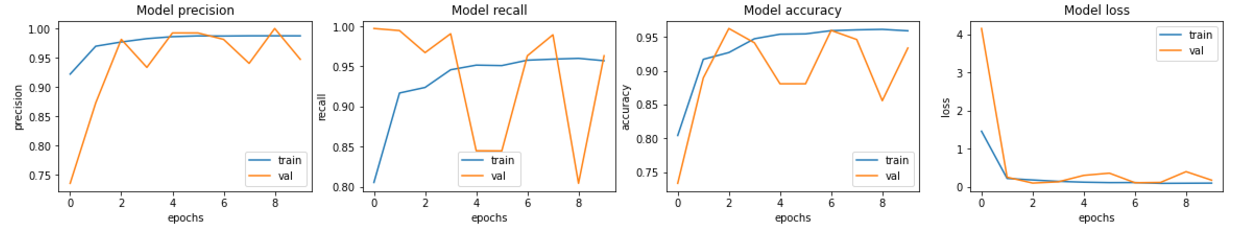

- loss가 가장 안정적인 결과가 나타났습니다.

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

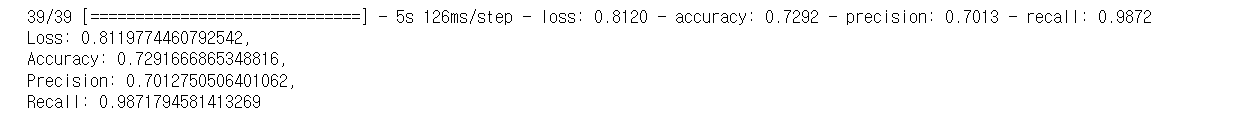

- 정확도는 70%지만 5.1 ~ 4 모델 중에서 가장 loss가 안정적으로 수렴한 걸 볼 수 있습니다.

## 회고
- 5.1과 5.2를 비교하는 과정에서 Data augmentation이 모델의 성능에 주는 영향을 확인할 수 있었습니다. 데이터를 쉽게 수집할 수 없는 도메인일 때, 활용도가 높아보였습니다.
- 5.1과 5.3을 비교하는 과정에서 Data imbalance를 해결하기 위해 추가한 class weight가 오히려 성능을 낮출 수도 있다는 것을 확인할 수 있었습니다.
- 모델 구조를 변경하고, 다른 모델과 비교해보는 과정에서 체계적인 실험의 필요성을 느꼈습니다.어떤 파라미터를 사용했고, 어떤 기법을 선택했으며, 어떤 모델의 종류를 사용했는 지 등에 대한 테스트 케이스 정리가 안 되어 있으면 결과를 비교하기 어렵겠다는 생각이 들었습니다.
- 위와 같은 고민을 하면서 jupyter notebook 안에 markdown으로 모델의 종류와 기법에 따라 최대한 분류해보았습니다.
- 또한, 모델이 커지고, 테스트 케이스가 많아지면 [mlflow](https://mlflow.org/), [wandb.ai](https://wandb.ai/)와 같은 다양한 MLops 툴을 활용해서 model tracking을 진행해볼 계획입니다.

## 참고
- https://acdongpgm.tistory.com/202
- https://paperswithcode.com/method/residual-block
- https://github.com/pytorch/vision/blob/1aef87d01eec2c0989458387fa04baebcc86ea7b/torchvision/models/resnet.py#L35
- https://keras.io/api/callbacks/early_stopping/